<a href="https://colab.research.google.com/github/RodriCalle/cc41_tf_201915889_201910127_201917028_201718169_20141a449/blob/master/Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import graphviz as gv
import math
import heapq as hq

In [2]:
def adjlShow(L, labels=None, directed=False, weighted=False, path=[], layout="sfdp"):
  g = gv.Digraph("G") if directed else gv.Graph("G")
  g.graph_attr["layout"] = layout
  g.edge_attr["color"] = "gray"
  g.node_attr["color"] = "orangered"
  g.node_attr["width"] = "0.1"
  g.node_attr["height"] = "0.1"
  g.node_attr["fontsize"] = "8"
  g.node_attr["fontcolor"] = "mediumslateblue"
  g.node_attr["fontname"] = "monospace"
  n = len(L)
  for u in range(n):
    g.node(str(u), labels[u] if labels else str(u))
  added = set()
  for v, u in enumerate(path):
    if u != None:
      g.edge(str(u), str(v), dir="forward", penwidth="2", color="orange")
      added.add(f"{u},{v}")
      added.add(f"{v},{u}")
  if weighted:
    for u in range(n):
      for v, w in L[u]:
        if not directed and not f"{u},{v}" in added:
          added.add(f"{u},{v}")
          added.add(f"{v},{u}")
          g.edge(str(u), str(v), str(w))
        elif directed:
          g.edge(str(u), str(v), str(w))
  else:
    for u in range(n):
      for v in L[u]:
        if not directed and not f"{u},{v}" in added:
          added.add(f"{u},{v}")
          added.add(f"{v},{u}")
          g.edge(str(u), str(v))
        elif directed:
          g.edge(str(u), str(v))
  return g

#Algorithm

In [3]:
qAlm = random.randint(50,100)
qEnt = random.randint(2500,5000)

almacenes, entregas = [], []

almacenx = np.random.randint(1,1000, size=qAlm)
almaceny = np.random.randint(1,1000, size=qAlm)

entregax = np.random.randint(1,1000, size=qEnt)
entregay = np.random.randint(1,1000, size=qEnt)

for i in range(qAlm):
  almacenes.append( [almacenx[i], almaceny[i]] )
for i in range(qEnt):
  entregas.append( [entregax[i], entregay[i]] )

#print("Cantidad de almacenes: ", qAlm)
#print(almacenes)
#print("Cantidad de puntos de entrega: ", qEnt)
#print(entregas)

In [4]:
almacenesFile = open('almacenes.csv', 'w')
with almacenesFile:
  writer = csv.writer(almacenesFile)
  writer.writerows(almacenes)

entregasFile = open('puntos_entrega.csv', 'w')
with entregasFile:
  writer = csv.writer(entregasFile)
  writer.writerows(entregas)

#with open('almacenes.csv', newline="") as almacenesFile:
#  reader = csv.reader(almacenesFile, delimiter=",")
#  for row in reader:
#    print(row)

#Figure

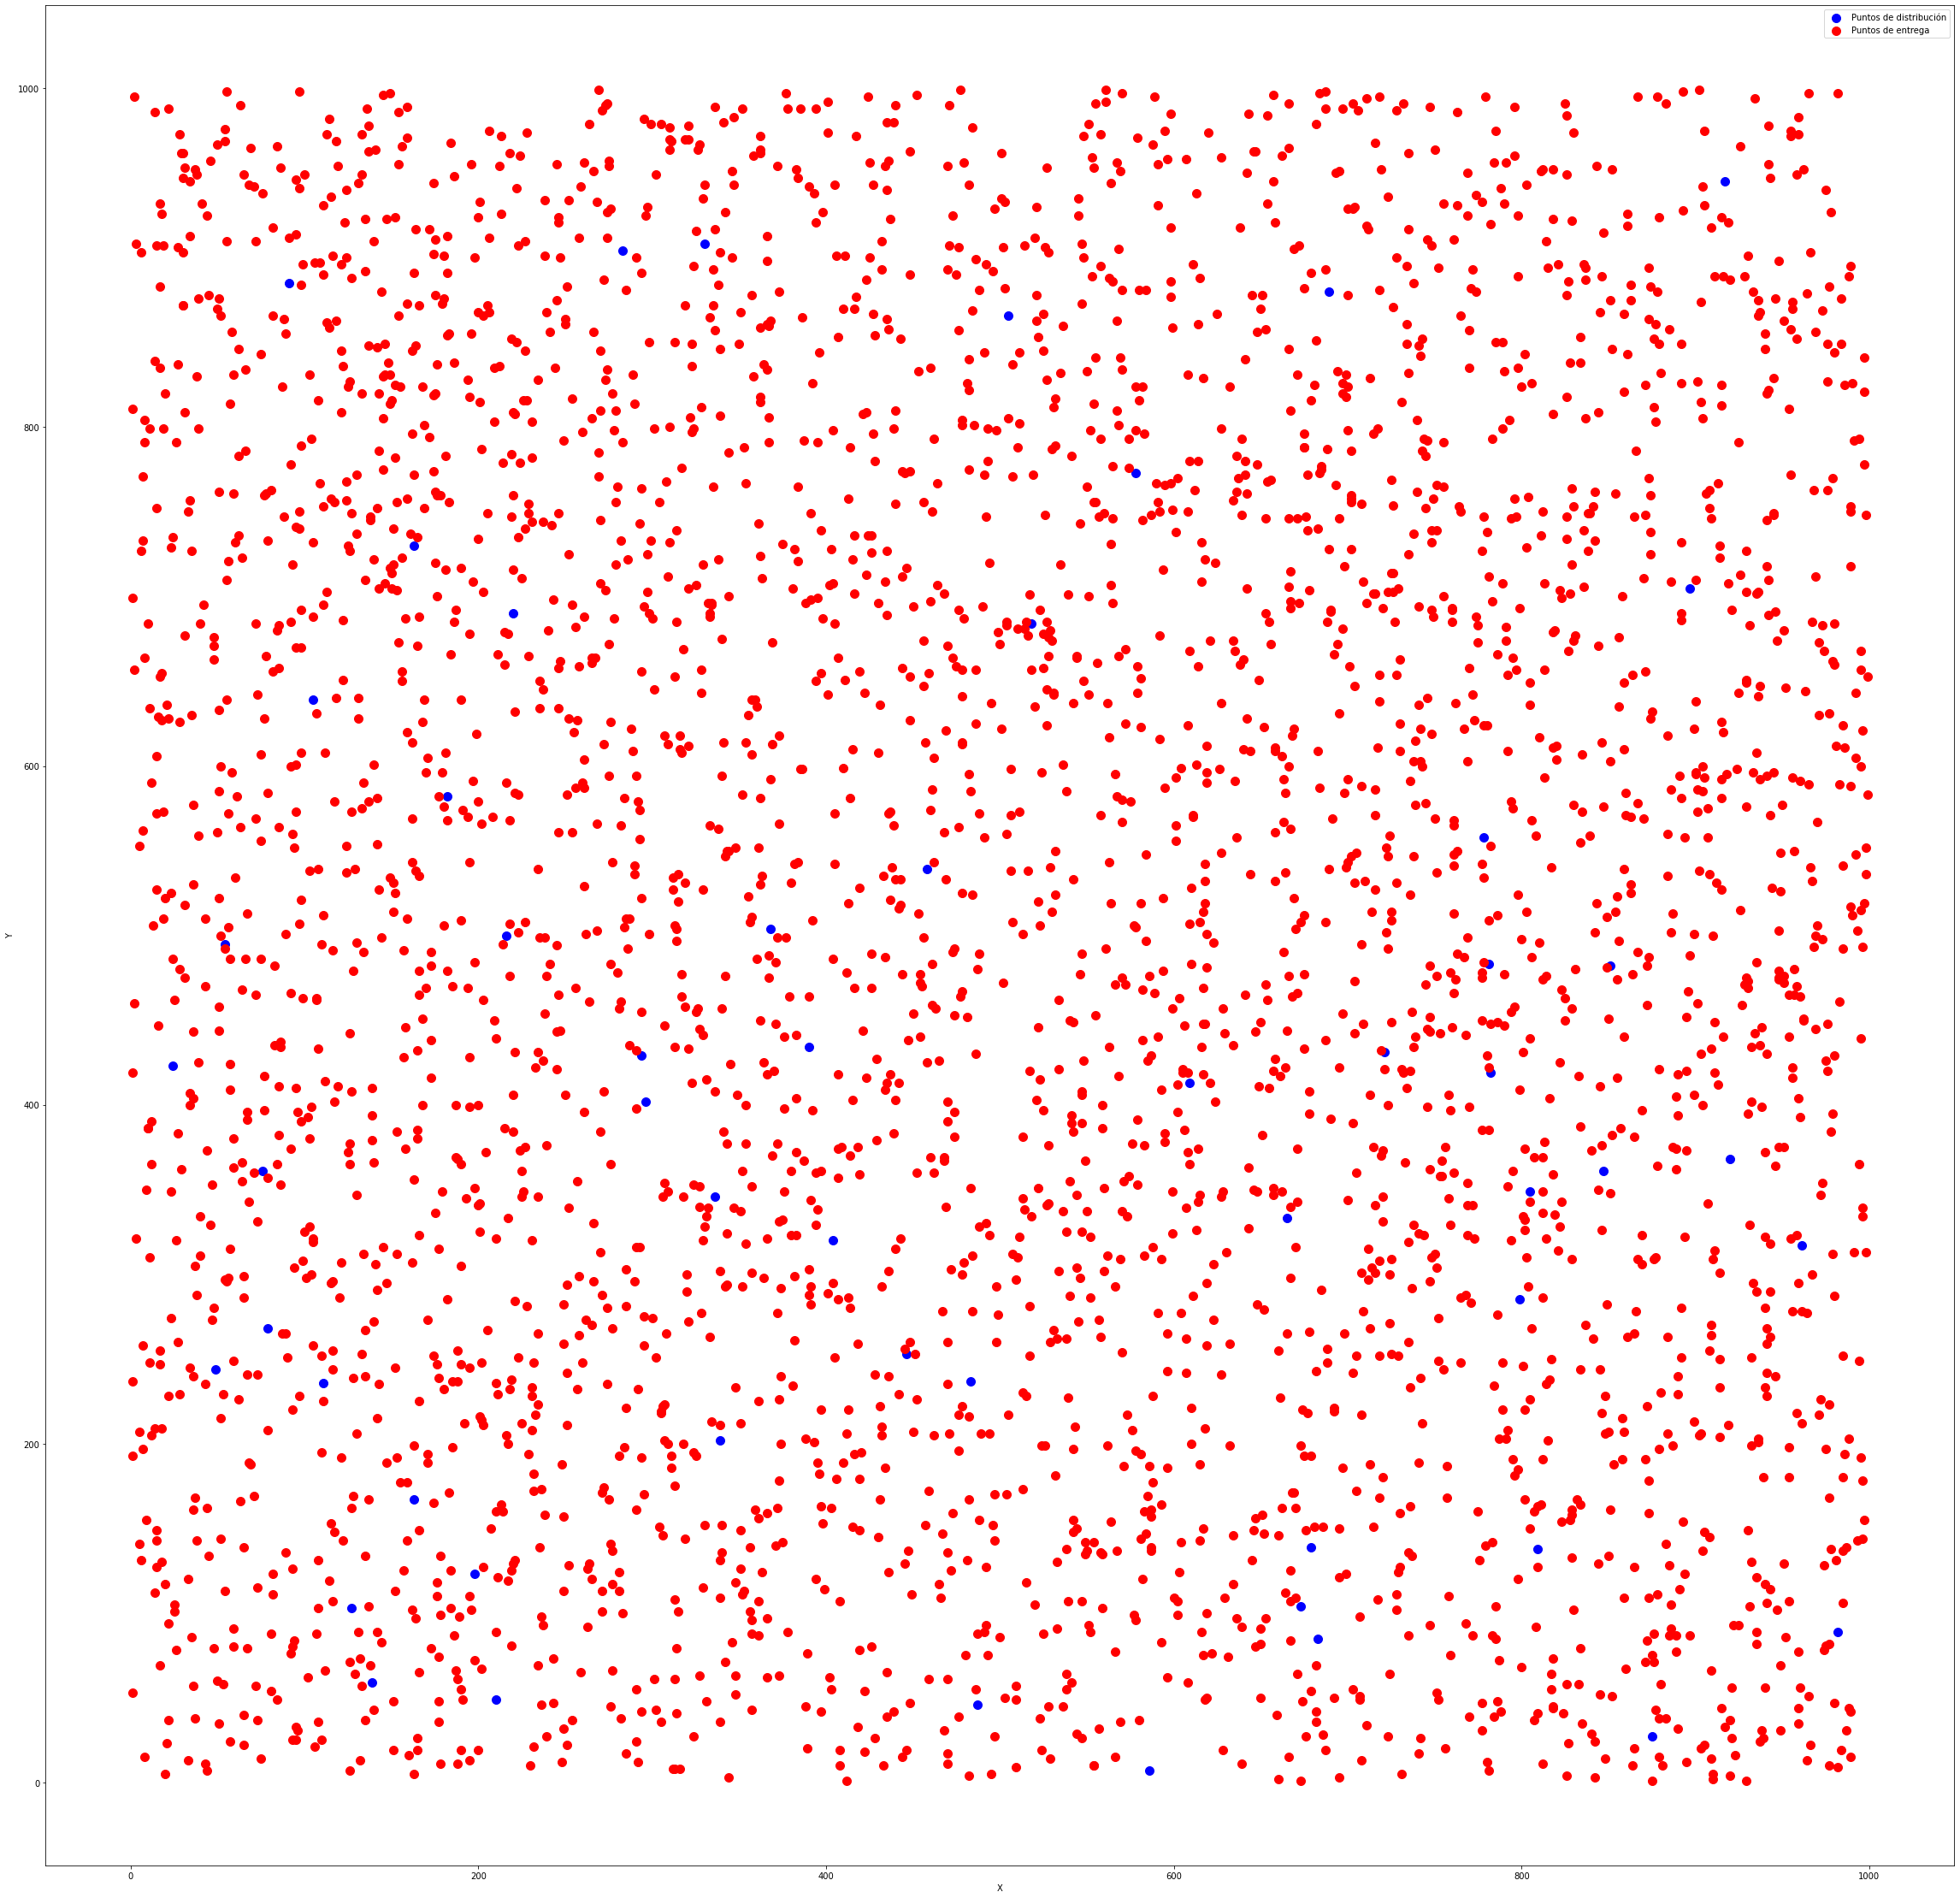

In [5]:
plt.figure(num=1, figsize=(40,40))
plt.scatter(almacenx,almaceny,s=100,color="blue", label="Puntos de distribución")
plt.scatter(entregax,entregay,s=100,color="red", label="Puntos de entrega")

plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

#Graphs

In [6]:
def setEmptyGraph(size):
  n = size*size
  G = [ [] for _ in range(n) ]
  for x in range(size):
    for y in range(size):
      if(size > x + 1):
        G[ ((x * size) + y) ].append(((x+1) * size) + y)
      if(0 <= x - 1):
        G[ ((x * size) + y) ].append(((x-1) * size) + y)
      if(size > y + 1):
        G[ ((x * size) + y) ].append((x * size) + (y+1))
      if(0 <= y - 1):
        G[ ((x * size) + y) ].append((x * size) + (y-1))
  return G

def setKnownPoints(size, almacen, entrega):
  id = ["Null"]*(size*size) #0 is null
  for a in almacen:
    x, y = a[0], a[1]
    pos = x*size + y # function to get position by x and y
    id[pos] = "A" # 1 is almacen
  for a in entrega:
    x, y = a[0], a[1]
    pos = x*size + y # function to get position by x and y
    id[pos] = "E" # 2 is delivery node
  return id

def getGraphWeighted(G):
  adjlListWeighted = [[] for i in range(len(G))]
  for i in range(len(G)):
    for j in range(len(G[i])):
      adjlListWeighted[i].append( ( G[i][j], round(math.sqrt( ( i%(len(G)/2)- G[i][j]%(len(G)/2) ) **2 + ( i // (len(G)/2) - G[i][j] // (len(G)/2)) **2) )) )
  return adjlListWeighted

[[3, 1], [4, 2, 0], [5, 1], [6, 0, 4], [7, 1, 5, 3], [8, 2, 4], [3, 7], [4, 8, 6], [5, 7]]
['A', 'A', 'Null', 'E', 'E', 'A', 'Null', 'Null', 'Null']
[[(3, 3), (1, 1)], [(4, 3), (2, 1), (0, 1)], [(5, 2), (1, 1)], [(6, 2), (0, 3), (4, 1)], [(7, 2), (1, 3), (5, 4), (3, 1)], [(8, 3), (2, 2), (4, 4)], [(3, 2), (7, 1)], [(4, 2), (8, 1), (6, 1)], [(5, 3), (7, 1)]]


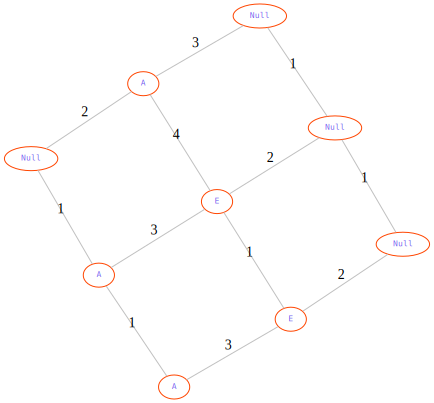

In [7]:
#Ejemplo de prueba
almacenes = [[0,1],[1,2],[0,0]]
entregas = [[1,0],[1,1]]

size = 3

G = setEmptyGraph(size)
print(G)

labels = setKnownPoints(size, almacenes, entregas)
print(labels)

GW = getGraphWeighted(G)
print(GW)

adjlShow(GW, labels=labels, weighted=True)

In [8]:
graphFile = open('adjlist.txt', 'w')
with graphFile:
  writer = csv.writer(graphFile)
  writer.writerows(G)

#Dijkstra

In [9]:
def dijkstra(G, s):
  n = len(G)
  visited = [False]*n
  path = [None]*n
  cost = [math.inf]*n
  cost[s] = 0
  queue = [(s, 0)]
  while queue:
    u, g_u = hq.heappop(queue)
    if not visited[u]:
      visited[u] = True
      for v in G[u]:
        f = g_u + 1
        if f < cost[v]:
          cost[v] = f
          path[v] = u
          hq.heappush(queue, (v, f))

  return path, cost

[None, 0, 1, 0, 1, 2, 3, 4, 5]
[0, 1, 2, 1, 2, 3, 2, 3, 4]


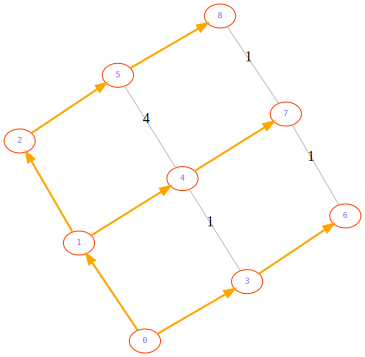

In [10]:
path, cost = dijkstra(G, 0)

print(path)
print(cost)

adjlShow(GW, path=path, weighted=True)

#Dijkstra para cada punto de entrega

In [21]:
def getAlmCoords(size, almacen):
  #id = ["Null"]*(size*size) #0 is null
  alm = []
  for a in almacen:
    x, y = a[0], a[1]
    pos = x*size + y # function to get position by x and y
    alm.append(pos)
    #id[pos] = "A" # 1 is almacen
  return alm

In [22]:
def getEntCoords(size, entrega):
  #id = ["Null"]*(size*size) #0 is null
  ent = []
  for a in entrega:
    x, y = a[0], a[1]
    pos = x*size + y # function to get position by x and y
    ent.append(pos)
    #id[pos] = "A" # 1 is almacen
  return ent

In [24]:
arreglo = getAlmCoords(3,almacenes)
print(arreglo)

[1, 5, 0]


In [25]:
arreglo2 = getEntCoords(3,entregas)
print(arreglo2)

[3, 4]


In [70]:
def dijkstraEntregas(almacenes, entregas, G):
  sol = [] 
  for i in almacenes:
    path, cost = dijkstra(G,i)
    for j in entregas:
      node = j
      p = [j]
      c = cost[j]
      while node != i:
        node = path[node]
        p.append(node)
      p.reverse()
      sol.append((i,j,c,p))
  return sol

In [71]:
djpd = dijkstraEntregas(arreglo, arreglo2,G)
print(djpd)

[(1, 3, 2, [1, 0, 3]), (1, 4, 1, [1, 4]), (5, 3, 2, [5, 4, 3]), (5, 4, 1, [5, 4]), (0, 3, 1, [0, 3]), (0, 4, 2, [0, 1, 4])]
